## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


---
## 1. Compute the camera calibration using chessboard images

First step in calculating camera matrix is using chessboard to acquire image points and obejct points

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Chess board size
chessboard_size = (9, 6)

# Since we know object points, we can prepare them as (0, 0, 0), (1, 0, 0) ...
objp = np.zeros((chessboard_size[1] * chessboard_size[0], 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Prepare input arrays for cv2.calibrateCamera()
object_points = []
image_points = []

# Load all images from camera_cal folder
images = glob.glob('camera_cal/calibration*.jpg')

# Iterate through images and append image points for coresponding
for image in images:
    # Read image
    img = cv2.imread(image)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    # Check if found corners successfuly
    if ret is True:
        # Append detected corners alongisde coresponding objp
        object_points.append(objp)
        image_points.append(corners)

        # Display found corners as sanity check
        cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
        cv2.imshow('Corners', img)
        cv2.waitKey(200)
        cv2.destroyAllWindows()
    else:
        # Opencv findChessboardCorners fails for for calibration images 1, 4, 5
        # I guess the reason is missing whitespace around chessboard in those images
        
        # Note from opencv site:

        '''
        The function requires white space (like a square-thick border, the wider the better) around the board to make the detection more robust in various 
        environments. Otherwise, if there is no border and the background is dark, the outer black squares cannot be segmented properly and so the square 
        grouping and ordering algorithm fails.
        '''
        print("Failed to find chessbpard corners for", image)


Failed to find chessbpard corners for camera_cal/calibration4.jpg
Failed to find chessbpard corners for camera_cal/calibration5.jpg
Failed to find chessbpard corners for camera_cal/calibration1.jpg


After determining image points for coresponding object points, we can do the actual camera calibration and undistort image where finding of chessboard corners failed (camera_cal/calibration1.jpg)

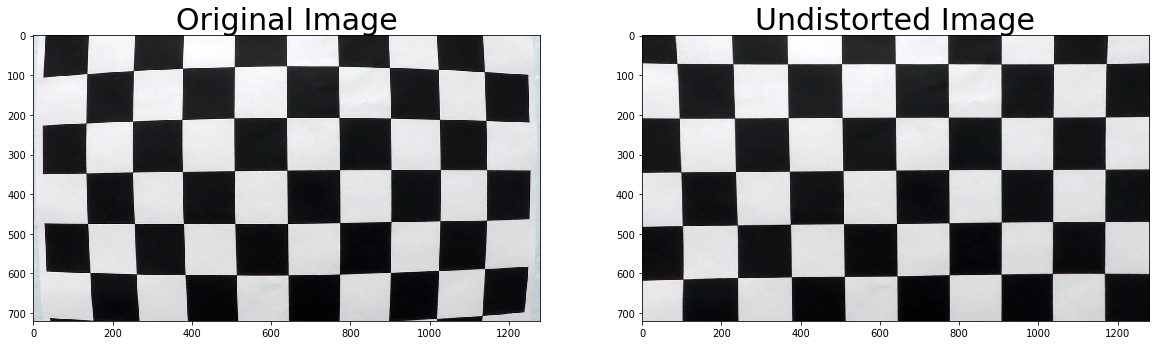

In [2]:
# Image to undistort
distorted_image = cv2.imread('camera_cal/calibration1.jpg')

# Acquire camera matrix and distortion coeffs
ret, mtx, dist_coef, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, (distorted_image.shape[1], distorted_image.shape[0]), None, None)

# Aplly undistortion on image
undistorted_image = cv2.undistort(distorted_image, mtx, dist_coef, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('output_images/undistort_output.jpg')


We can also save camera matrix and distortion coeffs for later usage

In [3]:
import pickle

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist_coef
pickle.dump(dist_pickle, open("calibration_output/wide_dist_pickle.p", "wb"))

## 2. Undistort raw image

After calibrating camera, we can proceed with undistorting raw frames as first step in our image processing pipeline.

First define function which will be used in pipeline:

In [4]:
def undistort_image(image, camera_matrix, distortion_coefficients):
    # Just apply opencv distortion
    return cv2.undistort(image, camera_matrix, distortion_coefficients, None, camera_matrix)

And after that test defined function

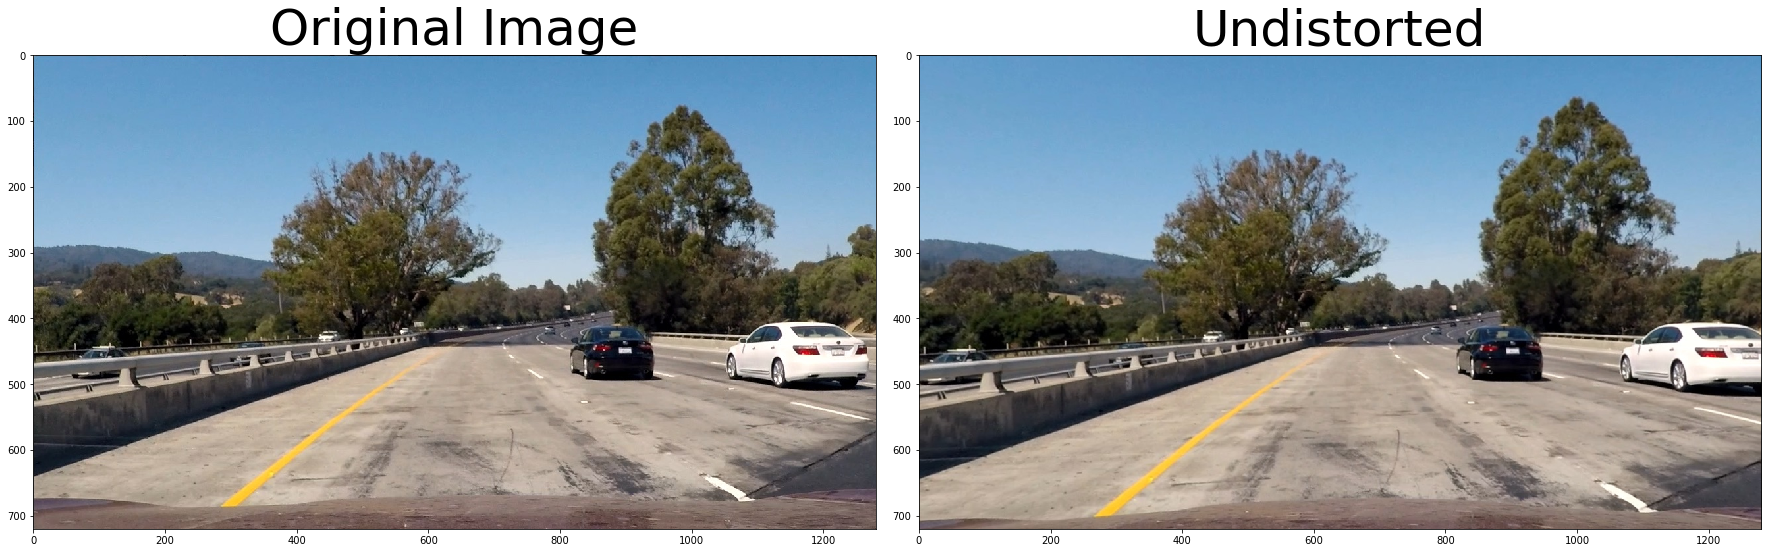

In [5]:
# Test for undistort_image function
image = cv2.imread('test_images/test1.jpg')

# Load saved distortion coefficients and camera matrix
dist_pickle = pickle.load(open("calibration_output/wide_dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

undistorted_image = undistort_image(image, mtx, dist)

# Dispaly output
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 3. Use color and gradients thresholding to create a thresholded binary image

Start by defining set of useful functions. 
Sobel in X direction + HLS S channel thresholding could prove to be quite good fit

In [6]:
def absolute_sobel_thresholding(img, thresh_low = 20, thresh_high = 100, kernel_size = 5):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply sobel in x direction
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel_size)

    # Absolute value
    absolute_sobel = np.abs(sobel)

    # Scale absolute to 0 - 255 range
    scaled_absolute = np.uint8(255 * absolute_sobel / np.max(absolute_sobel))

    # Prepare output
    binary_output = np.zeros_like(scaled_absolute)

    # Calculate output
    binary_output[(scaled_absolute > thresh_low) & (scaled_absolute < thresh_high)] = 1

    return binary_output

def color_thresholding(img, thresh_low = 170, thresh_high = 255):
    # Convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Isolate S channel
    s_channel = hls[:, :, 2]

    # Calculate binary output
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh_low) & (s_channel <= thresh_high)] = 1

    return binary_output

def gradient_direction_thresholding(img, sobel_kernel=5, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get gradient in x direction
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    # Get gradient in y direction
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Get absolute values for each image
    abs_sobel_x = np.abs(sobel_x)
    abs_sobel_y = np.abs(sobel_y)

    # Calculate gradient direction
    gradient_direction = np.arctan2(abs_sobel_y, abs_sobel_x)

    # Prepare output
    binary_output = np.zeros_like(gradient_direction)

    # Do the thresholding
    l_thresh, h_thresh = thresh
    binary_output[(gradient_direction >= l_thresh) & (gradient_direction <= h_thresh)] = 1

    return binary_output

# Will not be used since it introduces additional y direction edges
def gradient_magnitude_thresholding(img, sobel_kernel=5, mag_thresh=(0, 255)):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get gradient in x direction
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    # Get gradient in y direction
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # Calculate magnitude as mag = sqrt(sobel_x^2 + sobel_y^2)
    magnitude = np.sqrt(np.square(sobel_x) + np.square(sobel_y))

    # Scale the magnitude to 0 - 255 range
    scaled_magniuted = np.uint8(255 * magnitude / np.max(magnitude))

    # Create binary mask
    binary_output = np.zeros_like(scaled_magniuted)

    low_thresh, high_thresh = mag_thresh

    # Do the thresholding
    binary_output[(low_thresh <= scaled_magniuted) & (scaled_magniuted <= high_thresh)] = 1

    return binary_output

def apply_thresholds(img):
    # Sobel gradient thresholding
    gradient_binary = absolute_sobel_thresholding(img)

    # S channel thresholding
    color_binary = color_thresholding(img)

    # Apply gradient magnitude thresholding
    mag_binary = gradient_magnitude_thresholding(img, sobel_kernel = 5, mag_thresh = (80, 100))

    # Apply gradient direction thresholding
    direction_binary = gradient_direction_thresholding(img, sobel_kernel = 15, thresh = (0.7, 1.4))

    # Prepare binary output
    combined_binary = np.zeros_like(gradient_binary)

    # Combine thresholds
    combined_binary[((mag_binary == 1) & (direction_binary == 1)) | (color_binary == 1) | (gradient_binary == 1)] = 1

    return combined_binary


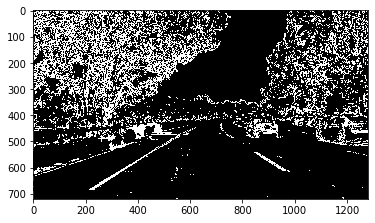

In [7]:
# Test set of thresholding functions
image = cv2.imread('test_images/test5.jpg')

binary_image = apply_thresholds(image)

plt.imshow(binary_image, cmap = 'gray')

## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

First define set of useful functions

In [8]:
def go_to_birdview_perspective(img):
    # Start by defining source points
    # Magic numbers acquired from gimp
    point1 = [280, 700]
    point2 = [595, 460]
    point3 = [725, 460]
    point4 = [1125, 700]
    source = np.float32([point1, point2, point3, point4])

    offset = 100

    # Define destination vertices
    # Magic numbers acquired from gimp
    dest_point1 = [250, 720]
    dest_point2 = [250, 0]
    dest_point3 = [1065, 0]
    dest_point4 = [1065, 720]
    destination = np.float32([dest_point1, dest_point2, dest_point3, dest_point4])

    transformation_matrix = cv2.getPerspectiveTransform(source, destination)
    inverse_transform_matrix = cv2.getPerspectiveTransform(destination, source)

    output = cv2.warpPerspective(img, transformation_matrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    return output, inverse_transform_matrix

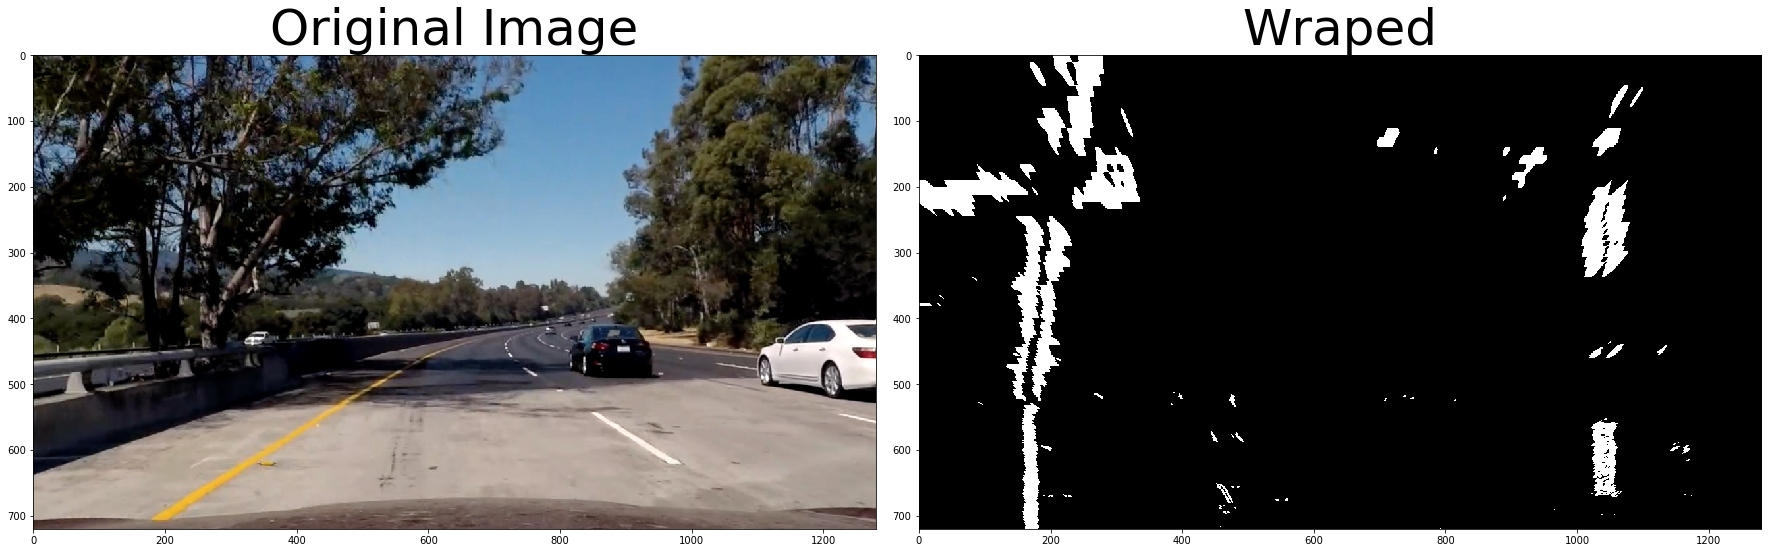

In [51]:
# Test functionality of perspective change
image = cv2.imread('test_images/test5.jpg')

# Undistort image
undistorted_image = undistort_image(image, mtx, dist)

# Convert image to binary
binary_image = apply_thresholds(undistorted_image)

# Change perspective
wraped_image, invers_transform_mat = go_to_birdview_perspective(binary_image)


# Dispaly output
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(wraped_image, cmap = 'gray')
ax2.set_title('Wraped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 5. Detect lane pixels and fit to find the lane boundary.

First, we need to find places in image where line start. We shall do that by using simple histogram. Calculate histogram value each column in the lower half of the image. This way columns with highest value shall be our lane lines beginings.

In [101]:
def find_lane_start(binary_warped):
    # Sum all the ones in binary image per column
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis = 0)

    # Find the mid point in histogram
    midpoint = np.int(histogram.shape[0] // 2)
    
    # Find left peak
    left_base = np.argmax(histogram[:midpoint])

    # Find right peak
    right_base = np.argmax(histogram[midpoint:]) + midpoint

    return left_base, right_base

def find_lane_pixels(binary_warped, number_of_windows = 9, margin = 100, min_pixel_detection = 50, draw_windows = False):
    # Calculate height of single window
    window_height = np.int(binary_warped.shape[0] // number_of_windows)

    # Find indices of all non zero pixels in the image
    non_zero = binary_warped.nonzero()
    non_zero_x = np.array(non_zero[1])
    non_zero_y = np.array(non_zero[0])

    # Set position of current window
    left_current_x, right_current_x = find_lane_start(binary_warped)

    # Prepare output lists in which we put indices of pixels that belong to the lane line
    left_lane_indices = []
    right_lane_indices = []

    # Optional draw output
    if draw_windows is True:
        out_image = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    for window in range(number_of_windows):
        # Identify window vertical boundaries
        window_y_low = binary_image.shape[0] - (window + 1) * window_height
        window_y_high = binary_image.shape[0] - window * window_height

        # Identify window horizontal boundaries
        left_window_x_low = left_current_x - margin
        left_window_x_high = left_current_x + margin

        right_window_x_low = right_current_x - margin
        right_window_x_high = right_current_x + margin

        # Optional draw
        if draw_windows is True:
            cv2.rectangle(out_image,(left_window_x_low, window_y_low),
                (left_window_x_high, window_y_high), (0,255,0), 4)
            cv2.rectangle(out_image,(right_window_x_low, window_y_low),
                (right_window_x_high, window_y_high),(0,255,0), 4)
        
        # Identify all pixels that belong to left window
        left_belonging_pixels_indices = ((non_zero_y >= window_y_low) &
            (non_zero_y < window_y_high) &
            (non_zero_x >= left_window_x_low) &
            (non_zero_x < left_window_x_high)).nonzero()[0]

        # Identify all pixels that belong to right window
        right_belonging_pixels_indices = ((non_zero_y >= window_y_low) &
            (non_zero_y < window_y_high) &
            (non_zero_x >= right_window_x_low) &
            (non_zero_x < right_window_x_high)).nonzero()[0]

        # Record belonging left line indices
        left_lane_indices.append(left_belonging_pixels_indices)

        # Record belonging right line indices
        right_lane_indices.append(right_belonging_pixels_indices)

        # Recalculate center of next iteration window
        if len(left_belonging_pixels_indices) > min_pixel_detection:
            left_current_x = int(np.mean(non_zero_x[left_belonging_pixels_indices]))

        if len(right_belonging_pixels_indices) > min_pixel_detection:
            right_current_x = int(np.mean(non_zero_x[right_belonging_pixels_indices]))

    # Concatenate all the recorded pixel coordinates
    left_lane_indices = np.concatenate(left_lane_indices)
    right_lane_indices = np.concatenate(right_lane_indices)

    # Extract left and right lane line pixel positions
    left_x = non_zero_x[left_lane_indices]
    left_y = non_zero_y[left_lane_indices]

    right_x = non_zero_x[right_lane_indices]
    right_y = non_zero_y[right_lane_indices]

    if draw_windows is True:
        return left_x, left_y, right_x, right_y, out_image
    else:
        return left_x, left_y, right_x, right_y
        
def calculate_curvature():
    

def fit_polynomial(binary_warped):
    # First find all indices of all pixels belonging to the lane lines
    left_line_x, left_line_y, right_line_x, right_line_y = find_lane_pixels(binary_warped)

    # Fit poly
    # Reverse x and y because we for single x value, we can have multiple points
    left_line = np.polyfit(left_line_y, left_line_x, 2)
    right_line = np.polyfit(right_line_y, right_line_x, 2)

    # Calculate concrete values so we can plot line
    plot_y = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_line_ploted = left_line[0] * plot_y ** 2 + left_line[1] * plot_y + left_line[2]
    right_line_ploted = right_line[0] * plot_y ** 2 + right_line[1] * plot_y + right_line[2]
    
    # Prepare output image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    out_img[left_line_y, left_line_x] = [255, 0, 0]
    out_img[right_line_y, right_line_x] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_line_ploted, plot_y, color='yellow')
    plt.plot(right_line_ploted, plot_y, color='yellow')

    return out_img

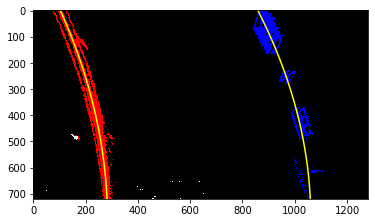

In [115]:
# Test functionality of perspective change
image = cv2.imread('test_images/test2.jpg')

# Undistort image
undistorted_image = undistort_image(image, mtx, dist)

# Convert image to binary
binary_image = apply_thresholds(undistorted_image)

# Change perspective
wraped_image, invers_transform_mat = go_to_birdview_perspective(binary_image)

# function_res = find_lane_pixels(wraped_image, draw_windows = True)
# plt.imshow(function_res[4])
# plt.show()

output = fit_polynomial(wraped_image)
plt.imshow(output)
plt.show()